# Analysis of real-world terrain data using polynomial regression and cross-validation.

#### Stage 1: Import Libraries

#### Explanation

This stage imports the necessary libraries for reading the data, performing regression, and visualizing the results.
- numpy: For numerical calculations.
- imageio: For reading TIFF images.
- matplotlib: For plotting the data.
- sklearn: For regression models, data scaling, and evaluation metrics.

In [1]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from matplotlib import cm


#### Stage 2: Load and Visualize Terrain Data

/var/folders/kk/5hm7hzcs6q7cj2gk85l1c7c40000gn/T/ipykernel_62108/3394741843.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain = imread('SRTM_data_Norway_2.tif')


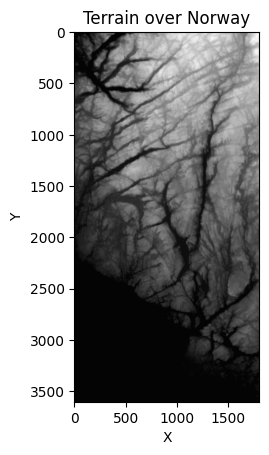

In [4]:
# Load data
terrain = imread('SRTM_data_Norway_2.tif')

# Display the terrain
plt.figure()
plt.title('Terrain over Norway')
plt.imshow(terrain, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


#### Explanation

Here, we are loading the real-world terrain data (from the .tif file) into Python, and displaying it as an image. This allows us to confirm that the data was loaded properly and helps us visualize the terrain before fitting any models.

#### Stage 3: Preparing Data for Regression

In [5]:

x_dim, y_dim = terrain.shape
x = np.linspace(0, 1, x_dim)
y = np.linspace(0, 1, y_dim)
x_grid, y_grid = np.meshgrid(x, y)
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()
z_flat = terrain.ravel()


z_flat_noisy = z_flat + 0.1 * np.random.normal(0, 1, z_flat.shape)


#### Explanation

Now we prepare the data so we can apply polynomial regression to it. We reshape the data into a format suitable for regression and optionally add noise.
First, we convert the 2D terrain data into flat arrays so the models can use it. Adding noise helps us simulate real-world imperfections in the data.

#### Stage 4: Create the Design Matrix

This stage creates a "design matrix" for polynomial regression based on the degree we specify.
A design matrix helps us fit polynomial surfaces to the terrain data.

In [6]:

def create_design_matrix(x, y, degree):
    X = np.ones((len(x), 1))
    for i in range(1, degree + 1):
        for j in range(i + 1):
            X = np.column_stack((X, (x ** (i - j)) * (y ** j)))
    return X


degree = 5


X = create_design_matrix(x_flat, y_flat, degree)


#### Explanation

What it does:

Builds the design matrix using the x and y coordinates of the terrain and the polynomial degree (in this case, degree 5).
This allows us to fit more complex surfaces (e.g., hills or valleys) to the terrain data.

#### Stage 5: Split the Data into Training and Testing Sets

We now split the data into a training set (for model fitting) and a testing set (for evaluating performance).

In [7]:

X_train, X_test, z_train, z_test = train_test_split(X, z_flat_noisy, test_size=0.3, random_state=42)


#### Explanation

Splits the design matrix and z-values into training (70%) and testing (30%) sets. The training data helps us train the model, and the testing data is used to check how well the model performs on unseen data.

#### Stage 6: Standardize the Data

This stage standardizes the data which is an important preprocessing step for many machine learning models especially for Ridge and Lasso regression.

In [8]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##### Explanation

Here the code scales the design matrix so all values have a mean of 0 and a standard deviation of 1, which helps the regression models perform better. This is important for Ridge and Lasso regressions because they are sensitive to the range of the data.

#### Stage 7: Fit the Regression Models

Now we fit three types of regression models: OLS , Ridge, and Lasso.

In [9]:
# Initialize models

ols_model = LinearRegression()
ridge_model = Ridge(alpha=0.1)
lasso_model = Lasso(alpha=0.1)


In [10]:

# Fit the OLS model
ols_model.fit(X_train_scaled, z_train)

LinearRegression()

In [11]:
# Fit the Ridge model
ridge_model.fit(X_train_scaled, z_train)

Ridge(alpha=0.1)

In [12]:
# Fit the Lasso model
lasso_model.fit(X_train_scaled, z_train)

/Users/bruker/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+10, tolerance: 3.971e+07
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

#### Explanation

Here , the code Fits the three regression models to the training data.This helps us compare different methods and see which one predicts the terrain most accurately.

##### Stage 8: Predict and Calculate MSE

We now use the trained models to predict the terrain data on the testing set and calculate the Mean Squared Error (MSE) for each model.

In [13]:

z_pred_ols = ols_model.predict(X_test_scaled)
z_pred_ridge = ridge_model.predict(X_test_scaled)
z_pred_lasso = lasso_model.predict(X_test_scaled)


mse_ols = mean_squared_error(z_test, z_pred_ols)
mse_ridge = mean_squared_error(z_test, z_pred_ridge)
mse_lasso = mean_squared_error(z_test, z_pred_lasso)


print(f"OLS MSE: {mse_ols}")
print(f"Ridge MSE: {mse_ridge}")
print(f"Lasso MSE: {mse_lasso}")


OLS MSE: 29444.070199447615
Ridge MSE: 29444.307350011906
Lasso MSE: 31734.744901636295


#### Explanation :

Here after training, we predict the terrain heights for the test data. The Mean Squared Error (MSE) tells us how close the predictions are to the real data. Lower MSE means the model is more accurate.

### Observations of Output :

- OLS and Ridge both models have almost identical MSE (~29444), meaning Ridge's regularization does not add significant improvement over OLS for this dataset.
- Lasso has higher MSE (~31734) indicates underperformance compared to OLS and Ridge. Lasso's tendency to shrink coefficients may be oversimplifying the model.
- Here, OLS and Ridge are more suitable for this terrain data, while Lasso might not capture the complexity needed for good predictions.

##### Stage 9: Cross-Validation with K-Fold

To ensure the models generalize well, we use cross-validation with K-fold to evaluate their performance.

In [14]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
ols_cv_scores = cross_val_score(ols_model, X_train_scaled, z_train, cv=kf, scoring='neg_mean_squared_error')
ridge_cv_scores = cross_val_score(ridge_model, X_train_scaled, z_train, cv=kf, scoring='neg_mean_squared_error')
lasso_cv_scores = cross_val_score(lasso_model, X_train_scaled, z_train, cv=kf, scoring='neg_mean_squared_error')

print(f"OLS CV MSE: {-np.mean(ols_cv_scores)}")
print(f"Ridge CV MSE: {-np.mean(ridge_cv_scores)}")
print(f"Lasso CV MSE: {-np.mean(lasso_cv_scores)}")


/Users/bruker/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.922e+09, tolerance: 3.178e+07
  model = cd_fast.enet_coordinate_descent(
/Users/bruker/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.822e+09, tolerance: 3.177e+07
  model = cd_fast.enet_coordinate_descent(
/Users/bruker/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

OLS CV MSE: 29473.946143898145
Ridge CV MSE: 29474.39085194804
Lasso CV MSE: 31760.969650164287


#### Explanation :

We use K-fold cross-validation to ensure that the models generalize well across different parts of the data. This helps us check whether the model performs consistently on various data splits, reducing the risk of overfitting.

#### Observations of Output :

The cross-validated MSE values for OLS and Ridge are extremely close, with a small difference of ~0.5. This confirms that the Ridge regularization doesn’t make a significant difference for this terrain data, as we also saw in the previous stage. Lasso has a noticeably higher cross-validated MSE (around 31760), which shows that it’s still underperforming compared to OLS and Ridge. This likely happens because Lasso is shrinking some coefficients to zero, which may oversimplify the model for terrain data.

#### Stage 10: Visualizing the Results

we visualize both the original terrain and the terrain predicted by the OLS model.

In [17]:
# Check the shape of data ,
print(x_grid.shape, y_grid.shape, terrain_transposed.shape, z_pred_grid_ols.shape)


(1801, 3601) (1801, 3601) (1801, 3601) (1801, 3601)


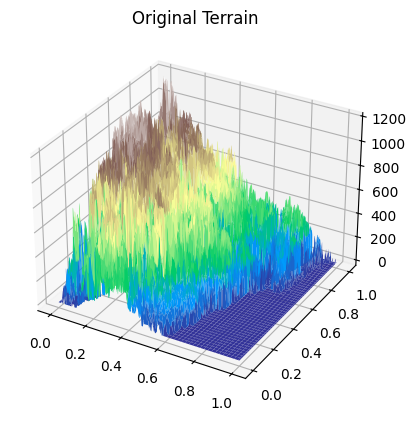

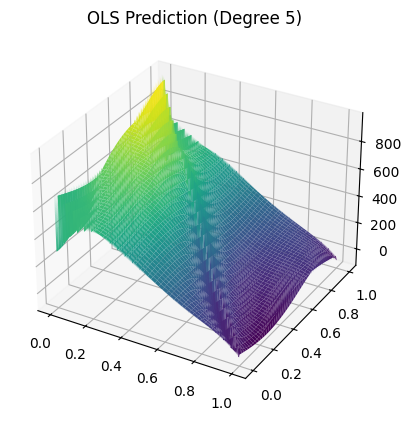

In [18]:

terrain_transposed = terrain.T


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, terrain_transposed, cmap=cm.terrain)
ax.set_title("Original Terrain")


z_pred_grid_ols = ols_model.predict(scaler.transform(create_design_matrix(x_flat, y_flat, degree))).reshape(x_dim, y_dim)


z_pred_grid_ols = z_pred_grid_ols.T

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(x_grid, y_grid, z_pred_grid_ols, cmap=cm.viridis)
ax2.set_title(f"OLS Prediction (Degree {degree})")

plt.show()


##### Explanation :

Here,
- The terrain data is transposed so its shape matches the grid dimensions.
- A 3D plot is created to visualize the original terrain using the transposed data.
- The OLS model predicts the terrain based on the grid points, and the predicted values are reshaped to match the grid.
- The predicted terrain data is transposed to align with the grid dimensions.
- A second 3D plot is created to visualize the predicted terrain from the OLS model.

#### Observations:

###### Original Terrain:

The original terrain plot shows a highly irregular and detailed surface with a wide range of elevations, which is typical for real-world terrain data.The elevation varies sharply, particularly in the center, with peaks and valleys clearly visible.


######  OLS Prediction (Degree 5):

The OLS prediction for a polynomial of degree 5 is much smoother, lacking the fine details present in the original terrain.The model captures some of the overall shape, but it significantly underfits the complexity of the terrain, as the predicted surface is too smooth and generalized.Higher-order details like sharp peaks and valleys are missing in the predicted surface, indicating that the polynomial degree might need to be increased or the model might not be complex enough to handle such data.

### Conclusion


In this analysis of real terrain data using polynomial regression (degree 5) and cross-validation, we observed the following:


- The OLS model with degree 5 gives a smooth fit, but it misses the finer details of the terrain, like sharp peaks and valleys. OLS and Ridge have almost the same MSE, showing Ridge's regularization doesn't add much improvement.

- Lasso performed worse with higher MSE and warnings, likely because it oversimplifies the model by shrinking important coefficients to zero.

- OLS and Ridge are more suitable for this terrain than Lasso, but even they struggle to capture the complexity. A degree of 5 is too low for this data.

- Higher-order polynomials or more advanced models like decision trees or neural networks could better capture the terrain’s details.

- The smooth predictions from OLS suggest that while the model can capture broad trends in the data, it lacks the flexibility to generalize well to highly variable real-world data, especially when using low-degree polynomials.